In [ ]:
import torch
from skimage import io
from skimage import transform
from collections import defaultdict

import torch
import numpy as np

from tqdm import trange
from torch import nn, Tensor

import matplotlib.pyplot as plt

import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor

# large figures er irriterende
plt.rcParams["figure.figsize"] = (4,4)

<Figure size 320x320 with 0 Axes>

<Figure size 320x320 with 0 Axes>

#### Define losses from loss.py

In [6]:
class ContentLoss(nn.Module):
    """Constructs a content loss function based on the VGG19 network.
    Using high-level feature mapping layers from the latter layers will focus more on the texture content of the image.

    Paper reference list:
        -`Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network <https://arxiv.org/pdf/1609.04802.pdf>` paper.
        -`ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks                    <https://arxiv.org/pdf/1809.00219.pdf>` paper.
        -`Perceptual Extreme Super Resolution Network with Receptive Field Block               <https://arxiv.org/pdf/2005.12597.pdf>` paper.
     """

    def __init__(self, extraction_layers: dict[str, float], device) -> None:
        """
        Content loss (in SRGAN) / Perceptual loss (in GramGAN).
        Follows the method outlined in GramGAN paper for computing a loss from the activation layer 
        in the pre-trained VGG19 network.
        
        Parameters
            extraction_layers (dict): A dict of layer
        """
        super(ContentLoss, self).__init__()

        # Get the name of the specified feature extraction node
        self.extraction_layers = extraction_layers
        self.device = device

        # Load the VGG19 model trained on the ImageNet dataset.
        model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).to(device)

        # Extract the thirty-sixth layer output in the VGG19 model as the content loss.
        self.feature_extractor = create_feature_extractor(model, list(extraction_layers))

        # set to validation mode
        self.feature_extractor.eval()

        # This is the VGG model preprocessing method of the ImageNet dataset.
        # The mean and std of ImageNet. See: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
        self.normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

        # Freeze model parameters.
        for model_parameters in self.feature_extractor.parameters():
            model_parameters.requires_grad = False

    def forward(self, sr_tensor: Tensor, gt_tensor: Tensor) -> Tensor:
        # Standardized operations
        sr_tensor = self.normalize(sr_tensor)
        gt_tensor = self.normalize(gt_tensor)

        # Find the feature map difference between the two images
        loss = torch.tensor(0.0, device = self.device)
        for name, weight in self.extraction_layers.items():
            sr_feature = self.feature_extractor(sr_tensor)[name]
            gt_feature = self.feature_extractor(gt_tensor)[name]

            # loss += weight * torch.linalg.vector_norm(sr_feature - gt_feature, ord = 1)
            loss += weight * F.mse_loss(sr_feature, gt_feature)
        
        return loss

In [39]:
class BestBuddyLoss(nn.Module):
    """ https://github.com/dvlab-research/Simple-SR/blob/08c71e9e46ba781df50893f0476ecd0fc004aa45/utils/loss.py#L54 """
    def __init__(self, alpha=1.0, beta=1.0, ksize=3, pad=0, stride=3, dist_norm='l2', criterion='l1'):
        super(BestBuddyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.ksize = ksize
        self.pad = pad
        self.stride = stride
        self.dist_norm = dist_norm

        if criterion == 'l1':
            self.criterion = torch.nn.L1Loss(reduction='mean')
        elif criterion == 'l2':
            self.criterion = torch.nn.L2loss(reduction='mean')
        else:
            raise NotImplementedError('%s criterion has not been supported.' % criterion)

    def forward(self, x, gt):
        p1 = F.unfold(x, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        B, C, H = p1.size()
        p1 = p1.permute(0, 2, 1).contiguous() # [B, H, C]

        p2 = F.unfold(gt, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2 = p2.permute(0, 2, 1).contiguous() # [B, H, C]

        gt_2 = F.interpolate(gt, scale_factor=0.5, mode='bicubic', align_corners = False)
        p2_2 = F.unfold(gt_2, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2_2 = p2_2.permute(0, 2, 1).contiguous() # [B, H, C]

        gt_4 = F.interpolate(gt, scale_factor=0.25, mode='bicubic',align_corners = False)
        p2_4 = F.unfold(gt_4, kernel_size=self.ksize, padding=self.pad, stride=self.stride)
        p2_4 = p2_4.permute(0, 2, 1).contiguous() # [B, H, C]
        p2_cat = torch.cat([p2, p2_2, p2_4], 1)

        score1 = self.alpha * batch_pairwise_distance(p1, p2_cat, self.dist_norm)
        score = score1 + self.beta * batch_pairwise_distance(p2, p2_cat, self.dist_norm) # [B, H, H]

        weight, ind = torch.min(score, dim=2) # [B, H]
        index = ind.unsqueeze(-1).expand([-1, -1, C]) # [B, H, C]
        sel_p2 = torch.gather(p2_cat, dim=1, index=index) # [B, H, C]

        loss = self.criterion(p1, sel_p2)

        return loss


def batch_pairwise_distance(x, y=None, dist_norm = 'l1'):
    '''
    Input: x is a BxNxd matrix
            y is an optional BxMxd matirx
    Output: dist is a BxNxM matrix where dist[b,i,j] is the square norm between x[b,i,:] and y[b,j,:]
            if y is not given then use 'y=x'.
    i.e. dist[b,i,j] = ||x[b,i,:]-y[b,j,:]||^2
    '''
    B, N, d = x.size()
    if dist_norm == 'l1':
        x_norm = x.view(B, N, 1, d)
        if y is not None:
            y_norm = y.view(B, 1, -1, d)
        else:
            y_norm = x.view(B, 1, -1, d)
        dist = torch.abs(x_norm - y_norm).sum(dim=3)
    elif dist_norm == 'l2':
        x_norm = (x ** 2).sum(dim=2).view(B, N, 1)
        if y is not None:
            M = y.size(1)
            y_t = torch.transpose(y, 1, 2)
            y_norm = (y ** 2).sum(dim=2).view(B, 1, M)
        else:
            y_t = torch.transpose(x, 1, 2)
            y_norm = x_norm.view(B, 1, N)

        dist = x_norm + y_norm - 2.0 * torch.bmm(x, y_t)
        # Ensure diagonal is zero if x=y
        if y is None:
            dist = dist - torch.diag_embed(torch.diagonal(dist, dim1=-2, dim2=-1), dim1=-2, dim2=-1)
        dist = torch.clamp(dist, 0.0, np.inf)
        # dist = torch.sqrt(torch.clamp(dist, 0.0, np.inf) / d)
    else:
        raise NotImplementedError('%s norm has not been supported.' % dist_norm)

    return dist

def pairwise_distance(x, y=None):
    '''
    Input: x is a Nxd matrix
            y is an optional Mxd matirx
    Output: dist is a BxNxM matrix where dist[i,j] is the square norm between x[i,:] and y[j,:]
            if y is not given then use 'y=x'.
    i.e. dist[i,j] = ||x[i,:]-y[j,:]||^2
    '''
    x_norm = (x ** 2).sum(1).view(-1, 1)
    if y is not None:
        y_t = torch.transpose(y, 0, 1)
        y_norm = (y ** 2).sum(1).view(1, -1)
    else:
        y_t = torch.transpose(x, 0, 1)
        y_norm = x_norm.view(1, -1)

    dist = x_norm + y_norm - 2.0 * torch.mm(x, y_t)
    # Ensure diagonal is zero if x=y
    if y is None:
        dist = dist - torch.diag(dist.diag())

    return torch.clamp(dist, 0.0, np.inf)




In [40]:
criterions = {
    "Adversarial"   : nn.BCEWithLogitsLoss(),
    "Content"       : ContentLoss(
        {
            "features.17" : 1/8,
            "features.26" : 1/4,
            "features.35" : 1/2
        }, 
        device='cpu'
    ),
    "Pixel"         : nn.MSELoss(),
    "L1"            : nn.L1Loss(),
    "BestBuddy"     : BestBuddyLoss()
}

#### Helper function for reading image as torch tensor

In [45]:
def read_im():
    im = io.imread("/zhome/c9/c/156514/SRGAN-ST/data-exploration/data/butterfly.png").astype(float)
    im = torch.tensor(im, dtype=torch.float32)
    im = im.permute(2,0,1)
    im = im[:, :192, :192]
    im = im[None, :, :, :]
    # im.shape: torch.Size([1, 3, 192, 192])
    return im

In [70]:
def im_to_tensor(im):
    im = torch.tensor(im, dtype=torch.float32)
    im = im.permute(2,0,1)
    im = im[:, :192, :192]
    im = im[None, :, :, :]
    return im

#### Explore how losses change as more noise is added to image
Add from 0.1 to 10 pct noise to an image and see how the losses change

In [46]:
noise_losses = defaultdict(list)

im = read_im()
noise = torch.randn_like(im)

for i in trange(100):
    noised_im = im + 0.001 * i * noise

    for name, criterion in criterions.items():
        loss = criterion(im, noised_im)
        noise_losses[name].append(loss)

100%|██████████| 100/100 [06:21<00:00,  3.82s/it]


/tmp/ipykernel_3588/417937020.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot(range(100), np.log(vals), "-", label=name)
/tmp/ipykernel_3588/417937020.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(100), np.log(vals), "-", label=name)


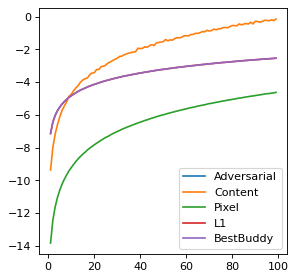

In [124]:
plt.figure(figsize=(4,4), dpi=80)
# Plot the findings
for name, vals in noise_losses.items():
    # if name == "Adversarial":# or name == 'Content':
    #     continue
    plt.plot(range(100), np.log(vals), "-", label=name)
plt.legend()
plt.show()

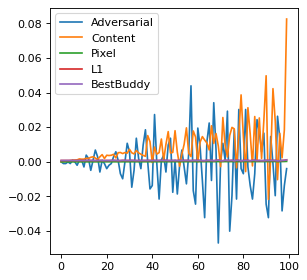

In [59]:
plt.figure(figsize=(4,4), dpi=80)

# Plot the gradient of the noised values
for name, vals in noise_losses.items():
    if name == "Adversarial" or name == 'Content':
        continue
    plt.plot(range(100), np.gradient(vals), "-", label=name)
plt.legend()
plt.show()

### Try rotating an image and see how it changes the loss.
Would probably be better with an image of a grid etc.

In [71]:

rotation_losses = defaultdict(list)

org_im = io.imread("/zhome/c9/c/156514/SRGAN-ST/data-exploration/data/butterfly.png").astype(float)
org_im_tensor = im_to_tensor(org_im)
for i in trange(360):
    
    rotated_im = transform.rotate(org_im, i)

    rotated_im_tensor = im_to_tensor(rotated_im)

    for name, criterion in criterions.items():
        loss = criterion(org_im_tensor, rotated_im_tensor)
        rotation_losses[name].append(loss)

100%|██████████| 360/360 [19:56<00:00,  3.32s/it]


/tmp/ipykernel_3588/3253510309.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot(range(360), np.log(vals), "-", label=name)
/tmp/ipykernel_3588/3253510309.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(360), np.log(vals), "-", label=name)


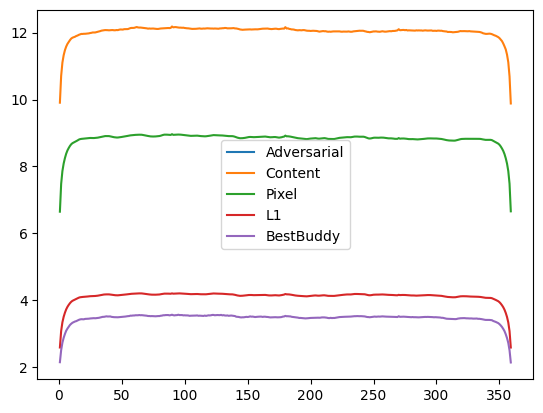

In [121]:
# Plot the findings
for name, vals in rotation_losses.items():
    # if name == "Content" or name == "Adversarial" or name == "Pixel":
    #     continue
    plt.plot(range(360), np.log(vals), "-", label=name)
plt.legend()
plt.show()

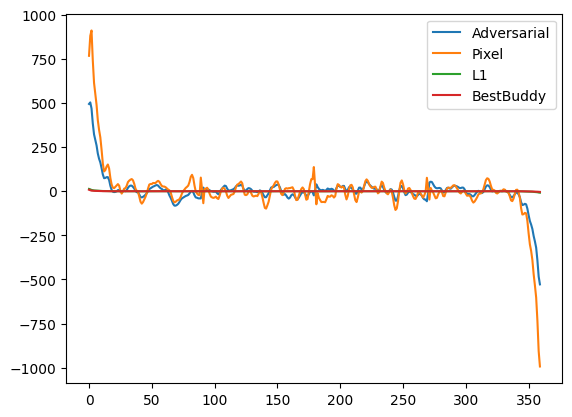

In [78]:
# Plot the gradients
for name, vals in rotation_losses.items():
    if name == "Content":# or name == "Adversarial":
        continue
    plt.plot(range(360), np.gradient(vals), "-", label=name)
plt.legend()
plt.show()

### Try to shift the image and see how it affects losses

In [101]:
from skimage.transform import AffineTransform, warp

def shift(image, vector):
    transform = AffineTransform(translation=vector)
    shifted = warp(image, transform, mode='wrap', preserve_range=True)

    return shifted.astype(image.dtype)

In [107]:

warp_losses = defaultdict(list)

org_im = io.imread("/zhome/c9/c/156514/SRGAN-ST/data-exploration/data/butterfly.png").astype(float)
org_im_tensor = im_to_tensor(org_im)

for i in trange(0, 192, 5):
    warp_im = shift(org_im, i)
    warp_im_tensor = im_to_tensor(warp_im)

    for name, criterion in criterions.items():
        loss = criterion(org_im_tensor, warp_im_tensor)
        warp_losses[name].append(loss)

100%|██████████| 39/39 [02:15<00:00,  3.47s/it]


/tmp/ipykernel_3588/3953173679.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(range(0, 192, 5), np.log(vals), "-", label=name)


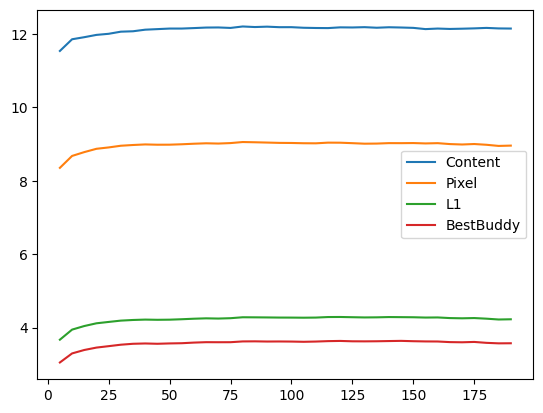

In [130]:
# Plot the losses
for name, vals in warp_losses.items():
    if name == "Adversarial":# or name == "Content" or name == "Pixel":
        continue
    plt.plot(range(0, 192, 5), np.log(vals), "-", label=name)
plt.legend()
plt.show()

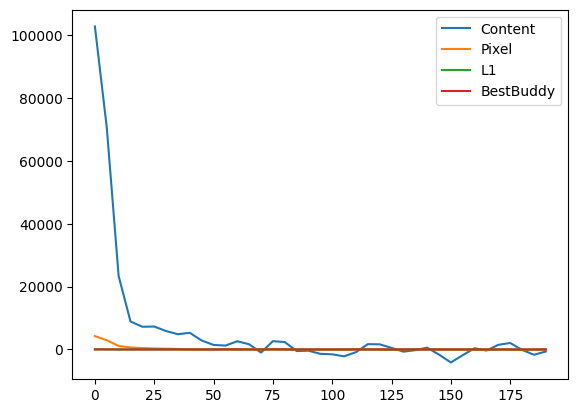

In [119]:
# Plot the gradients
for name, vals in warp_losses.items():
    if name == "Adversarial":# or name == "Adversarial":
        continue
    plt.plot(range(0, 192, 5), np.gradient(vals), "-", label=name)
plt.legend()
plt.show()

### Try downscaling and then upscaling image

In [139]:
from skimage.transform import resize

org_im = io.imread("/zhome/c9/c/156514/SRGAN-ST/data-exploration/data/butterfly.png")
org_im_tensor = im_to_tensor(org_im)

scale_losses = defaultdict(list)

for i in trange(1,10):
    small = resize(org_im, (192//i, 192//i))
    large = resize(small, (192, 192))
    large_im_tensor = im_to_tensor(large)

    for name, criterion in criterions.items():
        loss = criterion(org_im_tensor, large_im_tensor)
        scale_losses[name].append(loss)

100%|██████████| 9/9 [00:33<00:00,  3.68s/it]


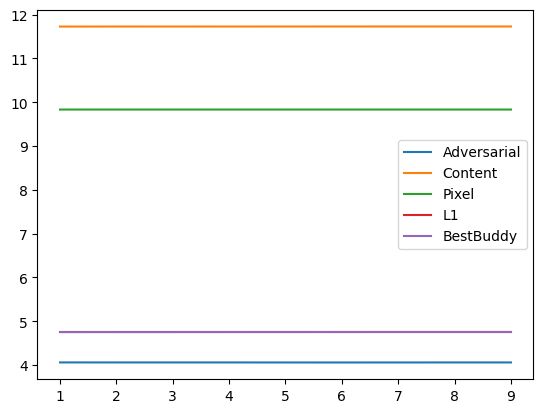

In [148]:
# Plot the losses
for name, vals in scale_losses.items():
    # if name == "Adversarial":# or name == "Content" or name == "Pixel":
    #     continue
    plt.plot(range(1,10), np.log(vals), "-", label=name)
plt.legend()
plt.show()